# DATASCI 420AB - Course Project
### Zach Gongaware

## Project Outline
### Project Goal

Each year, around 16,000 college football players graduate or become eligible for the NFL Draft.  Of these, only 253 (~1.6%) will be drafted, with an additional 100-200 becoming undrafted free agents. The goal of this project will be to predict which players will be drafted, and if so what round (1 - 7) they will be selected in.

**NOTE:** Supporting functions for this notebook are located in the *project_util.py* file.

### Data Sources

Credit to Sean J Taylor and his Learning the Draft project for original collection of data. There are three data sources for this project:

- college_stats.csv - Collegiate stats of players, drafted and undrafted
- combines.csv - Stats from yearly NFL Combine
- drafts.csv - Players drafted from years 2000 to 2015

### Methodology

This is primarily a classification problem, so either a decision tree or random forest is likely to be the most performant.

### Processing Steps (Pseudo-Code)
1. Data Source Collection and Preparation
   1. Load Draft data
       1. Create key field based on columns common to all three datasets
   2. Load Combine data
       1. Drop duplicate entries, create key fields, and create flag field noting combine participation
   3. Load College Stats data
       1. Create key field, roll up duplicate metrics
       2. Pivot to wide format table
       3. Fill NAs with 0
    4. Merge all three data sets based on the key field
        1. Combine equivalent columns
        2. Drop rows with missing position data
        3. Fill NAs 
2. Prepare data for modeling
   1. Convert height fields to inches
   2. Create position group field
   3. Impute missing combine stats based on position group
       1. Used mean - 1 standard deviation for each test.
   4. Classify colleges based on number of historically drafted players
       1. Assign to tiers based on quantiles
   5. One-Hot Encode Categorical Fields
       1. Position
       2. College
   6. Drop columns extraneous columns
   7. Scale all features using z-score
3. Divide data into train and test sets
   1. Isolate target field (Round) from each set
4. Fit Random Forest Regression Model
   1. Fit model to train set
   2. Feed test set to generate predictions
5. Assess Model Performance
   1. Primary Metrics - R2, MSE, MAE
6. Repeat Steps 2 - 5 until satisfied with results.
   1. Adjust model parameters
   2. Remove or add features based on their impact on the model
   
## Exploratory Data Analysis

In [1]:
# Load Scripting File
%run project_util.py

# Perform unit testing
perform_unit_tests()

# load each data set
draft = load_draft_data()
comb = load_combine_data()
stats = load_college_data()

### Draft Data

In [2]:
draft.shape

(4079, 10)

In [3]:
draft.head()

,year,round,pick,team,player,pos,age,college,url,key
0,2000,1,1,CLE,Courtney Brown,DE,22.0,Penn St.,http://www.sports-reference.com/cfb/players/co...,http://www.sports-reference.com/cfb/players/co...
1,2000,1,2,WAS,LaVar Arrington,LB,22.0,Penn St.,http://www.sports-reference.com/cfb/players/la...,http://www.sports-reference.com/cfb/players/la...
2,2000,1,3,WAS,Chris Samuels,T,23.0,Alabama,http://www.sports-reference.com/cfb/players/ch...,http://www.sports-reference.com/cfb/players/ch...
3,2000,1,4,CIN,Peter Warrick,WR,23.0,Florida St.,http://www.sports-reference.com/cfb/players/pe...,http://www.sports-reference.com/cfb/players/pe...
4,2000,1,5,BAL,Jamal Lewis,RB,21.0,Tennessee,http://www.sports-reference.com/cfb/players/ja...,http://www.sports-reference.com/cfb/players/ja...


Key field is derived from URL; or player name + year if URL is missing.

In [4]:
draft.dtypes

year         int64
round        int64
pick         int64
team        object
player      object
pos         object
age        float64
college     object
url         object
key         object
dtype: object

Position and college will have to be one-hot encoded to be factored into the model.  Year, Pick, Team, and Player Name will need to be excluded to prevent over-fitting.

In [5]:
draft.isnull().sum()

year          0
round         0
pick          0
team          0
player        0
pos           0
age         276
college      10
url        1087
key           0
dtype: int64

Around 1/4 of entries do not have URL and some are missing age.
### Combine Data

In [6]:
comb.shape

(5552, 15)

In [7]:
comb.head()

,year_combine,player_combine,pos_combine,college_combine,height,weight,forty,vertical,bench,broad,threecone,shuttle,url_combine,key,combine_participant
0,2000,John Abraham,OLB,South Carolina,6-4,252,4.55,NaN,NaN,NaN,NaN,NaN,NaN,John Abraham-2000,1
1,2000,Shaun Alexander,RB,Alabama,6-0,218,4.58,NaN,NaN,NaN,NaN,NaN,http://www.sports-reference.com/cfb/players/sh...,http://www.sports-reference.com/cfb/players/sh...,1
2,2000,Darnell Alford,OT,Boston College,6-4,334,5.56,25.0,23.0,94.0,8.48,4.98,NaN,Darnell Alford-2000,1
3,2000,Kyle Allamon,TE,Texas Tech,6-2,253,4.97,29.0,NaN,104.0,7.29,4.49,NaN,Kyle Allamon-2000,1
4,2000,Rashard Anderson,CB,Jackson State,6-2,206,4.55,34.0,NaN,123.0,7.18,4.15,NaN,Rashard Anderson-2000,1


Dimensions that match those in draft data set labeled with _combine

In [8]:
comb.dtypes

year_combine             int64
player_combine          object
pos_combine             object
college_combine         object
height                  object
weight                   int64
forty                  float64
vertical               float64
bench                  float64
broad                  float64
threecone              float64
shuttle                float64
url_combine             object
key                     object
combine_participant      int64
dtype: object

Height field will need to be converted to measurable integer.

In [9]:
comb.isnull().sum()

year_combine              0
player_combine            0
pos_combine               0
college_combine           0
height                    0
weight                    0
forty                   112
vertical               1338
bench                  1836
broad                  1591
threecone              1952
shuttle                1916
url_combine            1298
key                       0
combine_participant       0
dtype: int64

There is a lot of missing data in field tests from players who were injured or chose not to participate in certain drills.
### College Stats Data

In [10]:
stats.shape

(4488, 58)

In [11]:
stats.head()

metric,key,adj_yards_per_attempt,ast_tackles,attempts,comp_pct,completions,fum_forced,fum_rec,fum_tds,fum_yds,...,td_fr,td_int,td_kr,td_pr,td_rec,td_rush,td_tot,total_pts,twopm,yards_per_attempt
0,http://www.sports-reference.com/cfb/players/aa...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,http://www.sports-reference.com/cfb/players/aa...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,5.0,20.0,26.0,156.0,0.0,0.0
2,http://www.sports-reference.com/cfb/players/aa...,0.0,65.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0
3,http://www.sports-reference.com/cfb/players/aa...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,10.0,60.0,0.0,0.0
4,http://www.sports-reference.com/cfb/players/aa...,0.0,64.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data was pivoted to one row per key entry to match other sets.  Missing was data filled in with 0s.

In [12]:
stats.dtypes.value_counts()

float64    57
object      1
dtype: int64

In [13]:
stats.isnull().sum().sum()

0

Null values were taken care of in loading function. (*see project_util.py*)

### Combined Data Set

The *combine_data_sets()* function merges the data sets, combines equivalent columns (position, college, etc.) to fill out as many measurements as possible, and drops unneeded features.  Features were selected using a combination of lasso regression, review of the correlation plot (below) and domain knowledge.

In [14]:
combined = combine_data_sets(draft, comb, stats)

In [15]:
combined.shape

(5556, 28)

In [16]:
combined.head()

,year,round,pick,team,player,pos,age,college,key,height,...,completions,fum_forced,games,int,loss_tackles,pd,rush_att,scrim_yds,tackles,total_pts
0,2000.0,1.0,1.0,CLE,Courtney Brown,DE,22.0,Penn St.,http://www.sports-reference.com/cfb/players/co...,6-5,...,0.0,0.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0
1,2000.0,1.0,2.0,WAS,LaVar Arrington,LB,22.0,Penn St.,http://www.sports-reference.com/cfb/players/la...,6-3,...,0.0,0.0,23.0,3.0,0.0,0.0,0.0,0.0,0.0,6.0
2,2000.0,1.0,3.0,WAS,Chris Samuels,T,23.0,Alabama,http://www.sports-reference.com/cfb/players/ch...,6-5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000.0,1.0,4.0,CIN,Peter Warrick,WR,23.0,Florida St.,http://www.sports-reference.com/cfb/players/pe...,5-11,...,3.0,0.0,54.0,0.0,0.0,0.0,41.0,3705.0,0.0,228.0
4,2000.0,1.0,5.0,BAL,Jamal Lewis,RB,21.0,Tennessee,http://www.sports-reference.com/cfb/players/ja...,6-0,...,1.0,0.0,27.0,0.0,0.0,0.0,39.0,3152.0,0.0,126.0


In [17]:
combined.dtypes.value_counts()

float64    22
object      6
dtype: int64

Six remaining categorical fields to either encode or remove.

In [18]:
combined.isnull().sum()

year                      0
round                     0
pick                      0
team                      0
player                    0
pos                       0
age                    1753
college                   0
key                       0
height                  774
weight                  774
forty                   821
vertical               1893
bench                  2378
broad                  1919
threecone              2429
shuttle                2394
combine_participant       0
completions               0
fum_forced                0
games                     0
int                       0
loss_tackles              0
pd                        0
rush_att                  0
scrim_yds                 0
tackles                   0
total_pts                 0
dtype: int64

There are several thousand rows of data still missing values, particularly from the combine data set.  A key aspect of these fields is at players all have these measurements, even if they were not recorded in the data.  All players have a height, weight, age, etc; so to omit them would likely negatively impact results.  Missing combine data will therefore be imputed.

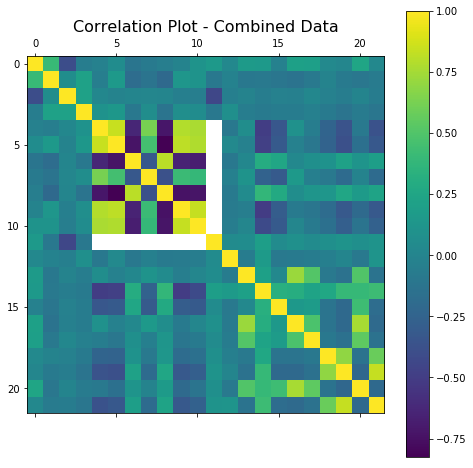

In [19]:
plt.figure(figsize=(8,8))
plt.matshow(combined.corr(), fignum=1)
plt.colorbar()
plt.title('Correlation Plot - Combined Data', fontsize=16)
plt.show()

There appears to be several pockets of highly correlated dimensions, particularly in the college statistics data.

In [20]:
c = combined.drop(['year','round','pick'],axis=1).corr().abs()
c = c.unstack().to_frame()

c.index = ['-'.join(col).strip() for col in c.index.values]
c = c.rename(columns={0:'corr'})

c[(0.5 < c['corr']) & (c['corr'] < 1.0)].sort_values(by='corr', ascending=False).head()

,corr
weight-forty,0.848300
forty-weight,0.848300
shuttle-threecone,0.836242
threecone-shuttle,0.836242
scrim_yds-total_pts,0.836045


There are several highly correlated fields both in the game statistics and combine data.  Lasso regression and domain knowledge was used to remove as many correlated features as possible, but several highly correlated fields still remain.  The difficulty here is many combine tests and game statistics interact with each other heavily.

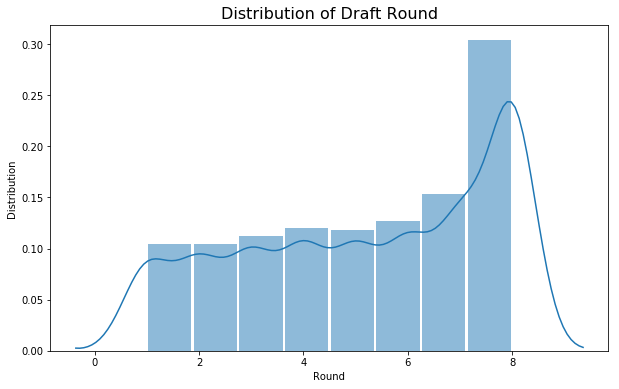

In [21]:
_ = plt.figure(figsize=(10,6))
_ = sns.distplot(combined['round'], bins=8, hist_kws={"histtype": "bar", "linewidth": 3, "alpha": 0.5, "rwidth":0.95, "align":"mid"})
_.set_xlabel('Round')
_.set_ylabel('Distribution')
_.set_title('Distribution of Draft Round', fontsize=16)
plt.show()

30% of the final population is undrafted, with the rest of the rounds sitting between 10-15%.  The variation in rounds is due to compensatory picks, which vary from year to year based on the outcome of NFL free agent signings.

## Modeling

Several models were attempted here with varying degrees of success.  In the end, a random forest regression model proved to perform the best.  Likely, this is because the target field has a continuous nature and it's order has meaning.  Regression models typically fit best in this scenario.  Random forests also perform better than other models with highly dimensional data and limited amounts of measurements.

In [22]:
# Load the data set, engineer features, and fit model.
%run project_util.py
perform_unit_tests()
draft = load_draft_data()
comb = load_combine_data()
stats = load_college_data()
combined = combine_data_sets(draft, comb, stats)
combined = engineer_features(combined)

X_train, y_train, X_test, y_test = perform_modeling_prep(combined, 'round')

rf, rf_predict, rf_r2 = perform_random_forest_regressor(X_train, y_train, X_test, y_test)

In [23]:
# Performance Metrics
output_performance(rf_r2, y_test, rf_predict, perf_type='R^2')

R^2: 0.526986367954011
MSE: 2.7449806667458634
MAE: 1.295106087022268


The model results show a fairly low R-squared measure, and a mean absolute error of 1.3.  On average, the model is off in its prediction by at least a round.

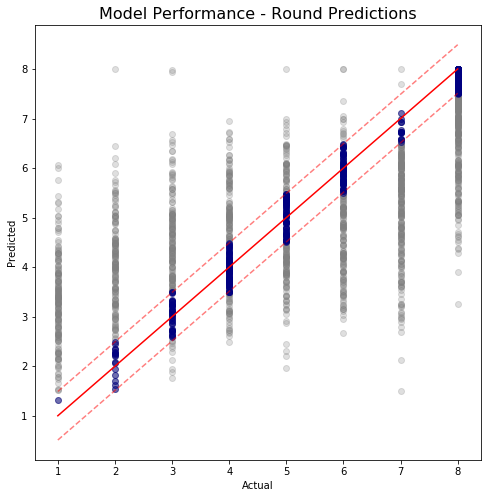

In [24]:
plot_performance(y_test, rf_predict)

The model appears to perform very poorly in the lower rounds.  Very few players seem to be predicted to rounds 1 or 2.

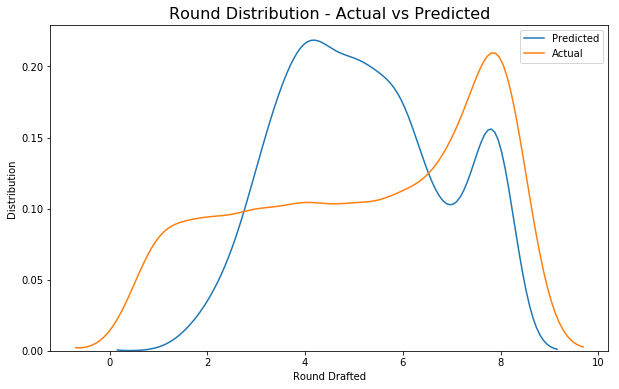

In [25]:
plot_prediction_distribution(y_test, rf_predict)

The distribution plot confirms the model's tendency to avoid lower-round predictions.  The model appears to greatly over-estimate the amount of players in the middle rounds of the draft.  Players from both early and late/undrafted rounds seem to clump around predictions between 3 and 5.

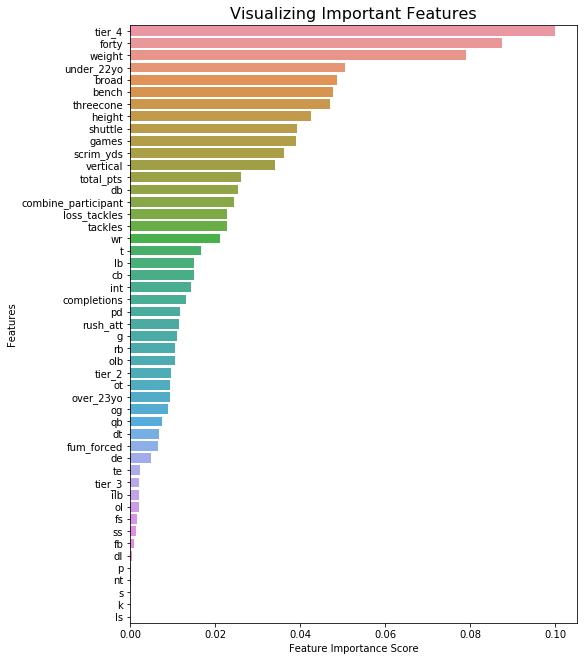

In [26]:
plot_feature_importance(rf.feature_importances_, X_train)

Many of the most important features are those that underwent imputation.  This may explain the model's preference for middle round predictions.  A better imputation method is likely needed to improve the model.

## Performance of Additional Models

#### Random Forest Classification

In [27]:
rfc, rfc_predict, rfc_r2 = perform_random_forest(X_train, y_train, X_test, y_test)

# Performance Metrics
output_performance(rfc_r2, y_test, rfc_predict, perf_type='accuracy')

Accuracy: 0.41457023060796644
MSE: 4.878930817610063
MAE: 1.439727463312369


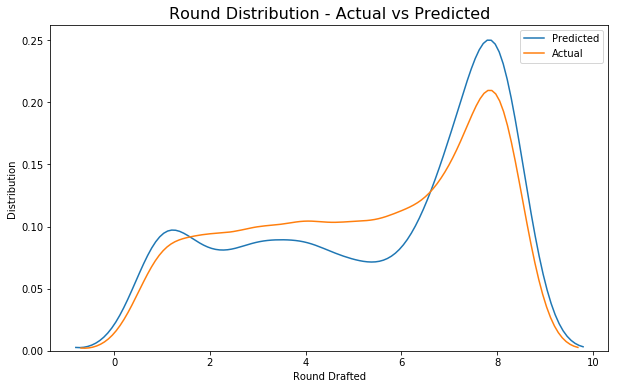

In [28]:
plot_prediction_distribution(y_test, rfc_predict)

Though the primary metrics of the random forest classifier are worse than the regressor, it appears to predict closer to the expected distribution of the round data.

#### Logistic Regression

In [29]:
lr, lr_predict, lr_acc = perform_logistic_regression(X_train, y_train, X_test, y_test)

# Performance Metrics
output_performance(lr_acc, y_test, lr_predict, perf_type='accuracy')

Accuracy: 0.4109014675052411
MSE: 5.927672955974843
MAE: 1.5775681341719077


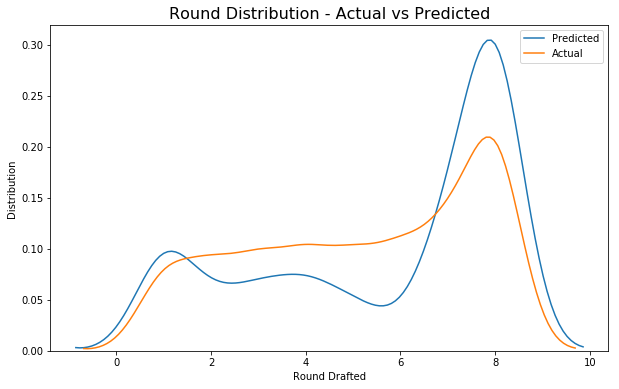

In [30]:
plot_prediction_distribution(y_test, lr_predict)

The logistic regressor seems to have trouble differentiating between the higher rounds and undrafted players.

#### Naive Bayes

In [31]:
nb, nb_predict, nb_acc = perform_naive_bayes(X_train, y_train, X_test, y_test)

# Performance Metrics
output_performance(nb_acc, y_test, nb_predict, perf_type='accuracy')

Accuracy: 0.2746331236897275
MSE: 14.281970649895179
MAE: 2.8825995807127884


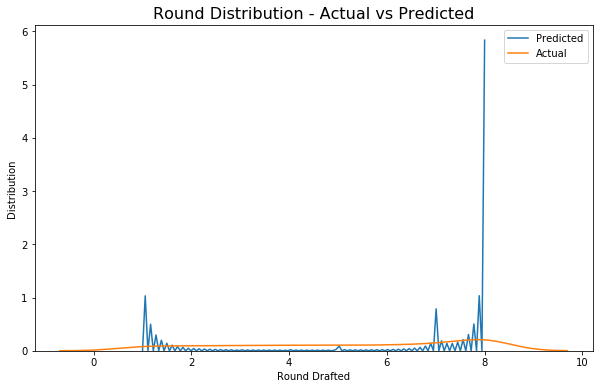

In [32]:
plot_prediction_distribution(y_test, nb_predict)

In [38]:
pd.DataFrame(nb_predict, columns=['predictions'])['predictions'].value_counts()

1.0    1466
8.0     368
7.0      57
5.0      11
4.0       2
3.0       2
2.0       2
Name: predictions, dtype: int64

The above plot is a mystery, but we can see from the counts in the cell below it that Naive Bayes vastly over-predicts the first round of the draft.  Very likely, the data must be restructered to better fit the expectations of this model.

## Closing Thoughts

The random forest regression model performs better than random chance, but has plenty of room of room for improvement.  It's obvious that the imputation methods used were not robust enough.  Combine statistics in particular seem very important to the model, so a better imputation may go a long way towards improving things.

A better method for dealing with highly correlated data may also help the model.  One possibility is "advanced" football statistics such as DVOA (Defense Value Over Average) or QBR (Quarterback Rating) that combine several features into a single metric.  Unfortunately, many of these statistics are proprietary, so purchasing additional data would be necessary to include them.

Lastly, additional measurements would likely help.  As mentioned in the introduction, nearly 16,000 college football players become draft eligible each year; but the final data set only included around 5,500 rows.  Data in this field seems difficult to come by, and seems to vary drastically based on the school of origin and whether the player pursued professional football (the vast majority do not).

I look forward to continuing to improve on this project.  Perhaps with some of the efforts mentioned above, it can begin to provide some real insight into the NFL Draft process.